# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

### План работ
 1. Откройте файл с данными и изучите его.
 2. Разделите исходные данные на обучающую, валидационную и тестовую выборки.
 3. Исследуйте качество разных моделей, меняя гиперпараметры.
 4. Проверьте качество модели на тестовой выборке.
 5. Проверьте модели на вменяемость.

## 1. Откройте и изучите файл

In [2]:
import pandas as pd
import numpy as np
from tqdm import notebook
from datetime import datetime
import timeit
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [4]:
users_data = pd.read_csv('datasets/users_behavior.csv')

In [5]:
users_data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [6]:
users_data['minutes'].value_counts()

0.00      40
1.00       3
2.00       3
564.01     3
260.94     2
          ..
81.29      1
105.01     1
523.84     1
507.52     1
185.18     1
Name: minutes, Length: 3142, dtype: int64

In [4]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


### Вывод

Данные открыты и изучены. Предобработка не требуется.

## 2. Разбейте данные на выборки

In [6]:
pretrain_data, valid_data = train_test_split(users_data, test_size=0.2, random_state=11)

In [7]:
train_data, test_data = train_test_split(pretrain_data, test_size=0.25, random_state=22)

In [8]:
data_list, data_type_list = ([train_data, valid_data, test_data],
                             ['в тренировочной выборке','в валидационной выборке', 'в тестовой выборке'])
for data,data_type in zip(data_list, data_type_list):
    print('Процент абонентов тарифа Ultra {}: {:.1%}'.format(data_type, data.is_ultra.mean()))

Процент абонентов тарифа Ultra в тренировочной выборке: 30.7%
Процент абонентов тарифа Ultra в валидационной выборке: 30.9%
Процент абонентов тарифа Ultra в тестовой выборке: 30.3%


### Вывод

Таким образом датасет был разбит на 3 выборки: тренировочную, валидационную и тестовую. Во всех выборках присутствует практически равный процент аббонентов тарифа Ultra.

## 3. Исследуйте модели

Для исследования модели, нужно ис каждой выборки выделить целевые признаки. По остальным признакам будет происходить предсказание

In [9]:
train_feature = train_data.drop('is_ultra', axis=1)
train_target = train_data['is_ultra']

valid_feature = valid_data.drop('is_ultra', axis=1)
valid_target = valid_data['is_ultra']

test_feature = test_data.drop('is_ultra', axis=1)
test_target = test_data['is_ultra']

Я создаю список, в котором будути записаны ключевы показатели моделей.

In [10]:
all_models = [] 

Поставлена задача классификации.

#### В первую очередь я решил прогнать датасет через дерево решений, как через самый простой алгоритм. 

In [12]:
timer = timeit.default_timer()
d_t_model = tree.DecisionTreeClassifier(random_state=22)
d_t_model.fit(train_feature, train_target)
train_time = timeit.default_timer() - timer
print('Время работы алгоритма: {}'.format(train_time))

Время работы алгоритма: 0.0138168316334486


In [13]:
d_t_score = d_t_model.score(valid_feature, valid_target)
d_t_score

0.713841368584759

Точность модели посредственная, и не перешагивает порог в 75%. Но в таблицу будет добавлена для сравнения.

In [14]:
# добавляю в общую таблицу модель
all_models.append({'algorithm' : 'Decision_Tree', 'accuracy' : d_t_score, 'train_time' : train_time})

#### Далее я рассмотрел логистическую регрессию.

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
timer = timeit.default_timer()
l_r_model = LogisticRegression(random_state=44, solver='liblinear')
l_r_model.fit(train_feature, train_target)
train_time = timeit.default_timer() - timer
print('Время работы алгоритма: {}'.format(train_time))

Время работы алгоритма: 0.014997540041804314


In [18]:
l_r_score = l_r_model.score(valid_feature, valid_target)
l_r_score

0.7013996889580093

Логистическая регрессия показала ужасный результат. 70% - это очень мало.

In [19]:
# добавляю в общую таблицу модель
all_models.append({'algorithm' : 'Logistic_Regression', 'accuracy' : l_r_score, 'train_time' : train_time})

<font color='blue'>Для модели логистической регрессии можно настраивать параметр C, перебирать его лучше по степеням: $10^{-5}, 10^{-4}, 10^{-3},\dots 10^5$, например. </font>


Рассмотрим более сложные алгоритмы.

#### Случайный лес.

Ниже, я перебрал от 1 до 100 количество деревьев с шагом в 1 и записал все наблюдения в датасет. Таким образом я получил таблицу со всеми результатами работы данного алгоритма случайного леса и смог отследить зависимости времени обучения и точности от числа деревьев. <i>(для градиентного спуска будут проделаны подобные действия)</i>

<font color='blue'>Для случайного леса параметр n_estimators можно перебирать с бОльшим шагом (20-50) и в бОльшем диапазоне (до 200-300). </font>


In [21]:
r_f_d = []
n=0
b = timeit.default_timer()
for estim in notebook.tqdm(range(1, 101, 1)):
    a = timeit.default_timer()
    r_f_model = RandomForestClassifier(n_estimators=estim, random_state=33, n_jobs=-1)
    r_f_model.fit(train_feature, train_target)
    r_f_score = r_f_model.score(valid_feature, valid_target)
    time = timeit.default_timer()-a
    r_f_d.append({'accuracy' : r_f_score, 'train_time' : time})
    if r_f_score >= 0.811:
        print('количество деревьев: {:^6} | точность предсказаний: {:^6} | время обучения: {:^6}'.format(estim, r_f_score.round(4), round(time, 4)))
        n +=1
r_f_data = pd.DataFrame(r_f_d, index = range(1,101,1))
print('Время работы алгоритма: {}, количество топовых моделей: {}'.format(timeit.default_timer() - b, n))

количество деревьев:   16   | точность предсказаний: 0.8134 | время обучения: 0.0931
количество деревьев:   17   | точность предсказаний: 0.8118 | время обучения: 0.0874
количество деревьев:   18   | точность предсказаний: 0.8134 | время обучения: 0.0995
количество деревьев:   19   | точность предсказаний: 0.8118 | время обучения: 0.1017
количество деревьев:   22   | точность предсказаний: 0.8134 | время обучения: 0.124 
количество деревьев:   23   | точность предсказаний: 0.8134 | время обучения: 0.1192

Время работы алгоритма: 26.82051193434745, количество топовых моделей: 6


In [22]:
top_r_f_data = r_f_data.sort_values('accuracy', ascending=False).head()
top_r_f_data

,accuracy,train_time
18,0.813375,0.099507
23,0.813375,0.119158
22,0.813375,0.124017
16,0.813375,0.093080
19,0.811820,0.101678


Случайный лес показывает отличные результаты, выше 81%, однако скорость работы алгоритма значительно ниже более простых алгоритмов.

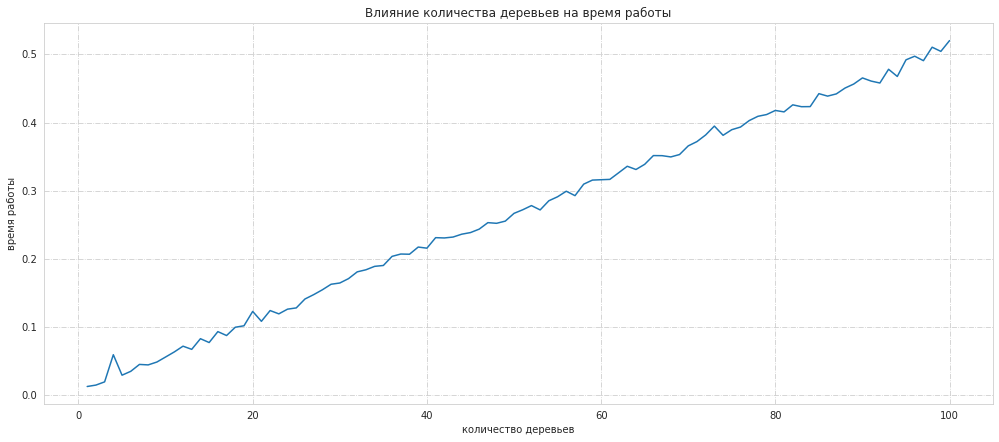

In [23]:
with sns.axes_style('whitegrid', {'grid.linestyle':'-.'}):
    fig, ax =plt.subplots(figsize=(17,7))
    sns.lineplot(y='train_time', x=r_f_data.index, data=r_f_data, ax=ax)
    plt.xlabel('количество деревьев')
    plt.ylabel('время работы')
    ax.set_title('Влияние количества деревьев на время работы')

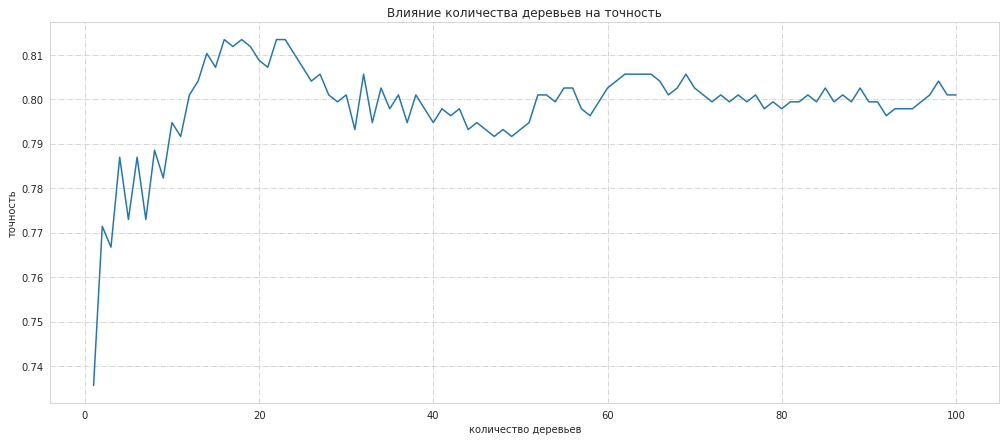

In [24]:
with sns.axes_style('whitegrid', {'grid.linestyle':'-.'}):
    fig, ax =plt.subplots(figsize=(17,7))
    sns.lineplot(y='accuracy', x=r_f_data.index, data=r_f_data, ax=ax)
    plt.xlabel('количество деревьев')
    plt.ylabel('точность')
    ax.set_title('Влияние количества деревьев на точность')

На графиках видно, что до 16 деревьев алгоритм очень бодро растет. Однако после 23 - начинает сильно переобучаться и терять в эффективности. <i>(вероятно, эти данные могут измениться при повторном прокручивание модели)</i>

In [25]:
# добавляю в общую таблицу топ 5 моделей
for ind in top_r_f_data.index:
    algorithm_name = 'Random_Forest'+'_' + str(ind)
    all_models.append({'algorithm' : algorithm_name, 'accuracy' : top_r_f_data.loc[ind,'accuracy'], 'train_time' : top_r_f_data.loc[ind,'train_time']})   

#### Градиентный спуск.

В практикуме его еще не было, но, мне захотелось познакомиться с ним. Сам алгоритм достаточно простой.

Ниже, я перебрал от 1 до 200 число итераций с шагом в 2 и записал все наблюдения в датасет. Таким образом я получил таблицу со всеми результатами работы данного алгоритма градиентного спуска и смог отследить зависимости времени обучения и точности от числа итераций.

In [27]:
g_b_d = []
n=0
b = timeit.default_timer()
for estim in notebook.tqdm(range(1, 201, 2)):
    a = timeit.default_timer()
    g_b_model = GradientBoostingClassifier(n_estimators=estim, random_state=11)
    g_b_model.fit(train_feature, train_target)
    g_b_score = g_b_model.score(valid_feature, valid_target)
    time = timeit.default_timer()-a
    g_b_d.append({'accuracy' : g_b_score, 'train_time' : time})
    if g_b_score >= 0.811:
        print('число итераций: {:^6} | точность предсказаний: {:^6} | время обучения: {:^6}'.format(estim, g_b_score.round(4), round(time, 4)))
        n +=1
g_b_data = pd.DataFrame(g_b_d, index = range(1,201,2))
print('Время работы алгоритма: {}, количество топовых моделей: {}'.format(round(timeit.default_timer() - b, 3), n))

число итераций:   17   | точность предсказаний: 0.8134 | время обучения: 0.0383
число итераций:   23   | точность предсказаний: 0.8118 | время обучения: 0.0478
число итераций:   25   | точность предсказаний: 0.8134 | время обучения: 0.0423
число итераций:   33   | точность предсказаний: 0.8149 | время обучения: 0.0706
число итераций:   35   | точность предсказаний: 0.8118 | время обучения: 0.0938
число итераций:   37   | точность предсказаний: 0.8118 | время обучения: 0.112 
число итераций:   39   | точность предсказаний: 0.8118 | время обучения: 0.1164
число итераций:   41   | точность предсказаний: 0.8149 | время обучения: 0.1031
число итераций:   99   | точность предсказаний: 0.8118 | время обучения: 0.1601
число итераций:  101   | точность предсказаний: 0.8118 | время обучения: 0.1621
число итераций:  103   | точность предсказаний: 0.8118 | время обучения: 0.1658
число итераций:  105   | точность предсказаний: 0.8118 | время обучения: 0.1669
число итераций:  107   | точность предск

In [28]:
top_g_b_data = g_b_data.sort_values('accuracy', ascending=False).head()
top_g_b_data

,accuracy,train_time
33,0.814930,0.070605
41,0.814930,0.103129
17,0.813375,0.038323
25,0.813375,0.042330
101,0.811820,0.162142


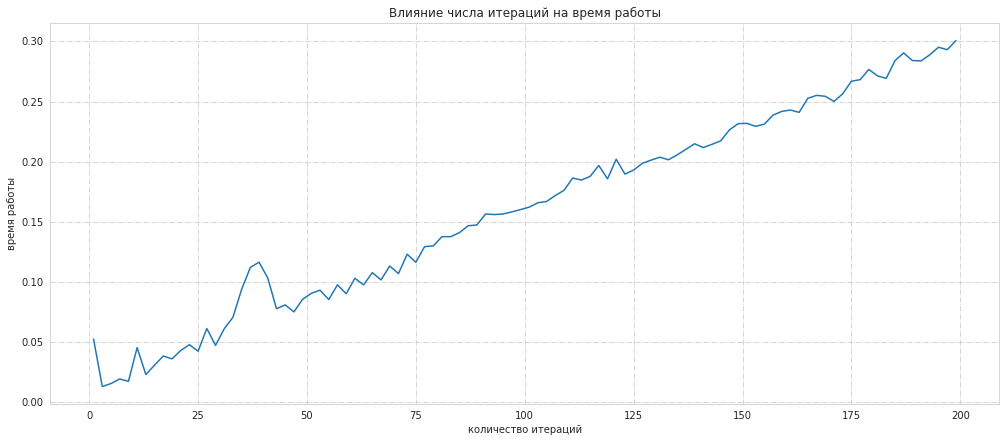

In [29]:
with sns.axes_style('whitegrid', {'grid.linestyle':'-.'}):
    fig, ax =plt.subplots(figsize=(17,7))
    sns.lineplot(y='train_time', x=g_b_data.index, data=g_b_data, ax=ax)
    plt.xlabel('количество итераций')
    plt.ylabel('время работы')
    ax.set_title('Влияние числа итераций на время работы')

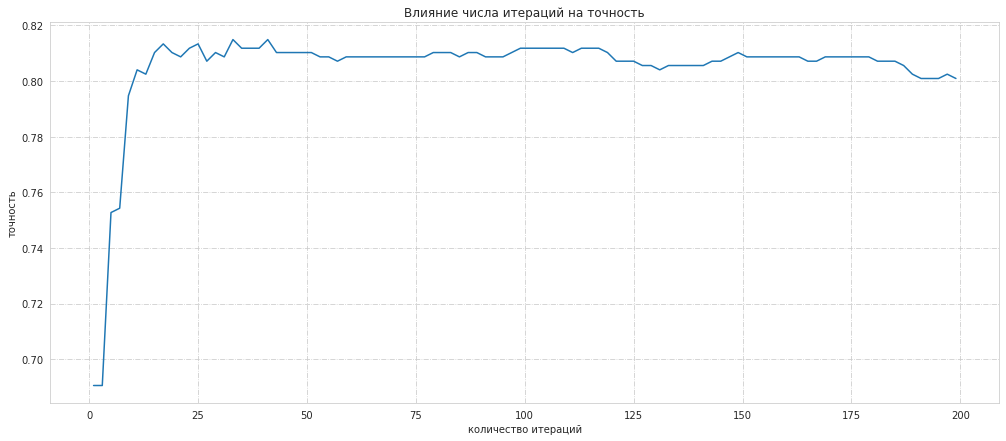

In [30]:
with sns.axes_style('whitegrid', {'grid.linestyle':'-.'}):
    fig, ax =plt.subplots(figsize=(17,7))
    sns.lineplot(y='accuracy', x=g_b_data.index, data=g_b_data, ax=ax)
    plt.xlabel('количество итераций')
    plt.ylabel('точность')
    ax.set_title('Влияние числа итераций на точность')

Точность очень быстро растет и на 33 итерации достигает пика. После, примерно, 110 итерации алгоритм начинает переобучаться, но значительно меньше, чем случайный лес. К тому же в сравнении с ним, градиентный спуск, в целом, работает быстрей.
<i>(вероятно, эти данные могут измениться при повторном прокручивание модели)</i>

In [31]:
# добавляю в общую таблицу топ 5 моделей
for ind in top_g_b_data.index:
    algorithm_name = 'Gradient_Boosting'+'_' + str(ind)
    all_models.append({'algorithm' : algorithm_name, 'accuracy' : top_g_b_data.loc[ind,'accuracy'], 'train_time' : top_g_b_data.loc[ind,'train_time']})   

#### Анализ полученных данных.
Далее, я изучил собранные данные.

Для начала, я создал из полученого списка датафрейм для удобства.

In [32]:
models_data = pd.DataFrame(all_models)
models_data

,algorithm,accuracy,train_time
0,Decision_Tree,0.713841,0.013817
1,Logistic_Regression,0.701400,0.014998
2,Random_Forest_18,0.813375,0.099507
3,Random_Forest_23,0.813375,0.119158
4,Random_Forest_22,0.813375,0.124017
5,Random_Forest_16,0.813375,0.093080
6,Random_Forest_19,0.811820,0.101678
7,Gradient_Boosting_33,0.814930,0.070605
8,Gradient_Boosting_41,0.814930,0.103129
9,Gradient_Boosting_17,0.813375,0.038323


Далее я посмотрел на отношение на полученных данных на графиках. (красная линяя - порог точности в 75%)

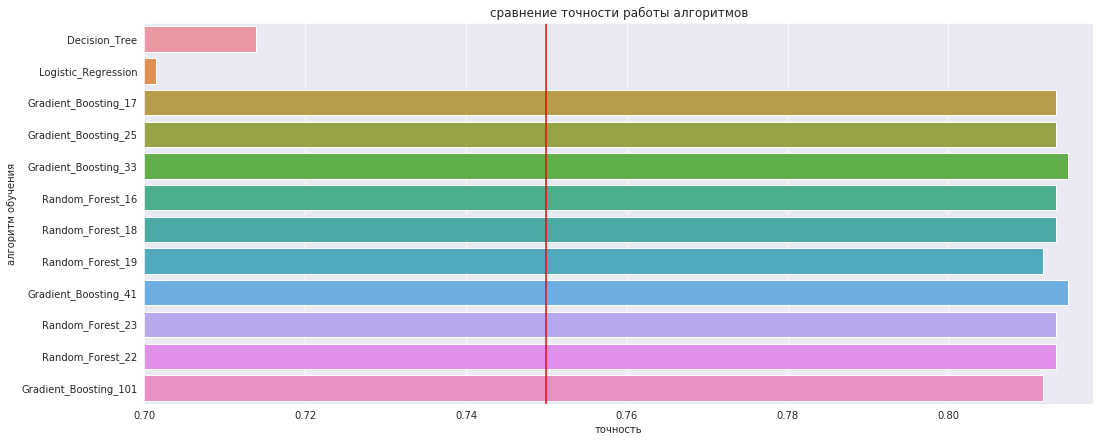

In [33]:
with sns.axes_style('darkgrid', {'grid.linestyle':'-'}):
    fig, ax = plt.subplots(figsize=(17,7))
    plt.axvline(0.75, color='red')
    sns.barplot(x='accuracy', y='algorithm', data = models_data.sort_values('train_time'),ax=ax)
    plt.xlabel('точность')
    plt.ylabel('алгоритм обучения')
    ax.set_xlim(0.7, 0.818)
    ax.set_title('сравнение точности работы алгоритмов')

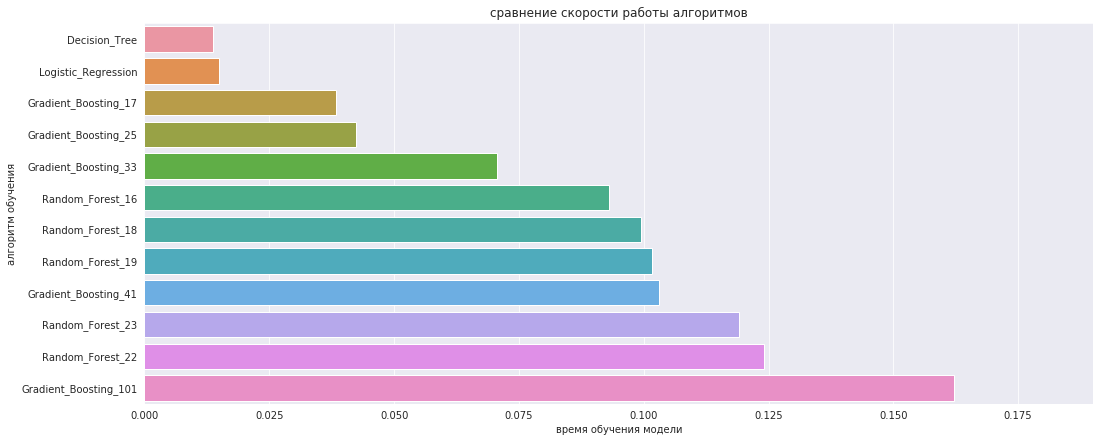

In [34]:
with sns.axes_style('darkgrid', {'grid.linestyle':'-'}):
    fig, ax = plt.subplots(figsize=(17,7))
    sns.barplot(x='train_time', y='algorithm', data = models_data.sort_values('train_time'),ax=ax)
    plt.xlabel('время обучения модели')
    plt.ylabel('алгоритм обучения')
    ax.set_xlim(0, 0.19)
    ax.set_title('сравнение скорости работы алгоритмов')

Алгоритмы дерева решений и логистической регрессии работают очень быстро, однако выдают плохой результат. Случайный лес работает медленней, но выдает хороший результат. Среди всех "лесов", лучшим по соотношению скорость - точность будет тот, в котором присутсвует 16 деревьев.

Однако он все равно хуже алгоритма градиентного спуска и по скорости, и по точности.

Самым оптимальным решением будет градиентный спуск с 33 итерациями.

### Вывод

Проанализировав 4 алгоритма, я пришел к выводу, что оптимальней всего будет использовать алгоритм градиентного спуска с 33 итерациями.

## 4. Проверьте модель на тестовой выборке

In [35]:
timer = timeit.default_timer()
fin_model = GradientBoostingClassifier(n_estimators=33, random_state = 11)
fin_model.fit(train_feature,train_target)
print('время работы алгоритма: {:.3} сек.'.format(timeit.default_timer() - timer))

время работы алгоритма: 0.0715 сек.


In [36]:
fin_model_score = fin_model.score(test_feature,test_target)
print('Процент точности на тестовой выборке: {:.1%}.'.format(fin_model_score))

Процент точности на тестовой выборке: 82.4%.


## 5. (бонус) Проверьте модели на адекватность

Для проверки адекватности модели я использую DummyClassifier. Я не совсем понял, что он такое, но прочитал, что он буквально "догадывается". В любом случае это лучше, чем датасет заполненный 50 на 50 или вообще случайный.

In [37]:
from sklearn.dummy import DummyClassifier

In [38]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_feature,train_target)
dummy_clf.predict(test_feature)
print(end='')

In [39]:
print('Точность алгоритма градиентного спуска с 33 итерациями выше фиктивного классификатора на {:.1%}'.format(fin_model_score - dummy_clf.score(test_feature,test_target)))

Точность алгоритма градиентного спуска с 33 итерациями выше фиктивного классификатора на 12.8%


# Общий вывод

Таким образом, я получил модел, способную примерно в 80% случаев подобрать верный тариф для того или иного человека. Я использовал градиентный спуск, так как он оказался наиболее эффективным в данной задаче.